In [1]:
import pandas as pd
import numpy as np
import shap
import warnings
import joblib
import sys
import psutil
import GPUtil
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, GroupKFold
from collections import defaultdict
from time import time
from datetime import timedelta
from importlib.metadata import version

# printout of python version
print("="*50, "Python Version", "="*50)
print(f"python version: {sys.version}")
print(f"xgboost:        {version('xgboost')}")
print(f"shap:           {version('shap')}")

# printout of hardware
print("="*50, "Hardware", "="*50)
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU: {gpu.name}")
print(f"CPU cores: {psutil.cpu_count(logical=False)}")
print(f"RAM: {psutil.virtual_memory().total / 1024 / 1024 / 1024 :.2f} GB")

warnings.filterwarnings('ignore')

================================================== Python Version ==================================================
python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
xgboost:        2.1.1
shap:           0.46.0
================================================== Hardware ==================================================
GPU: NVIDIA GeForce RTX 4090
CPU cores: 16
RAM: 63.82 GB


# read data function

In [2]:
def read_abcd(path, cols, na_values):
    
    df = pd.read_csv(path, sep='\t', index_col='subjectkey', na_values=na_values)
    df = df.drop(df.index[0])
    
    for col in cols:
        df[col] = pd.to_numeric(df[col])
        df = df[cols]

    df = df.reset_index()
    df = df.sort_values(['subjectkey', 'interview_age'])
    df = df.drop_duplicates(subset=['subjectkey'], keep='first')
    df = df.drop(columns=['interview_age'])
    df = df.set_index('subjectkey')
    
    df_show = abcd_ysu02.join(df)
    df_show = df_show.drop(columns=[
        'isip_1d_2',
        'isip_5_2',
        'isip_1b_yn'
    ])
     
    for col in df_show.columns:
        print('{:<30}    n = {:<10}    mean = {:<10.4f}    sum = {:<10.1f}'.\
              format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
    print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))
    
    return df

# y-target variable

In [3]:
file_abcd_ysu02 = r'D:\gregn\data\ABCD\abcd3\abcd_ysu02.txt'
abcd_ysu02 = pd.read_csv(file_abcd_ysu02, sep='\t', index_col='subjectkey')
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02.index[0])
cols = [
    'interview_age',
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
]

for col in cols:
    abcd_ysu02[col] = pd.to_numeric(abcd_ysu02[col])
    abcd_ysu02 = abcd_ysu02[cols]
    
abcd_ysu02 = abcd_ysu02.reset_index()
abcd_ysu02 = abcd_ysu02.sort_values(['subjectkey', 'interview_age'])
abcd_ysu02 = abcd_ysu02.drop_duplicates(subset=['subjectkey'], keep='first')
abcd_ysu02 = abcd_ysu02.drop(columns=['interview_age'])
abcd_ysu02 = abcd_ysu02.set_index('subjectkey')
    
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_5_2 == 3].index) # drop accidental 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_5_2 == 2].index) # drop furtive 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_1b_yn == 0].index) # drop religious 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_1d_2 > 10].index) # drop older than 10

abcd_ysu02['isip_1d_2'] = abcd_ysu02['isip_1d_2'].fillna(0)

y = abcd_ysu02['isip_1d_2'].values
y = np.where(y>0, 1, y)

unique, counts = np.unique(y, return_counts=True)

print('number of subjects: {:>10}\n\n[0] never sipped: {:>12}\n[1] sipped by age 10:{:>9}'.\
      format(len(y), counts[0], counts[1]))

number of subjects:      10707

[0] never sipped:         9209
[1] sipped by age 10:     1498


# abcd_tbss01

In [4]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_tbss01.txt'

cols = [
    'interview_age',
    'nihtbx_picvocab_fc',
    'nihtbx_flanker_fc',
    'nihtbx_list_fc',
    'nihtbx_cardsort_fc',
    'nihtbx_pattern_fc',
    'nihtbx_picture_fc',
    'nihtbx_reading_fc',
    'nihtbx_fluidcomp_fc',
    'nihtbx_cryst_fc',
    'nihtbx_totalcomp_fc',
]

na_values = [None]
abcd_tbss01 = read_abcd(path, cols, na_values)

nihtbx_picvocab_fc                n = 9986          mean = 52.2267       sum = 521535.6  
nihtbx_flanker_fc                 n = 9981          mean = 46.0127       sum = 459252.8  
nihtbx_list_fc                    n = 9945          mean = 49.3761       sum = 491045.8  
nihtbx_cardsort_fc                n = 9984          mean = 47.3935       sum = 473176.4  
nihtbx_pattern_fc                 n = 9967          mean = 45.2361       sum = 450868.4  
nihtbx_picture_fc                 n = 9976          mean = 49.4500       sum = 493312.9  
nihtbx_reading_fc                 n = 9976          mean = 49.2431       sum = 491248.9  
nihtbx_fluidcomp_fc               n = 9791          mean = 45.7027       sum = 447475.3  
nihtbx_cryst_fc                   n = 9842          mean = 50.8272       sum = 500241.6  
nihtbx_totalcomp_fc               n = 9788          mean = 47.6174       sum = 466079.1  

subjects:     10707
features:        10


# lmtp201

In [5]:
path = r'D:\gregn\data\ABCD\abcd3\lmtp201.txt'

cols = [
    'interview_age',
    'lmt_scr_perc_correct',
    'lmt_scr_rt_correct',
]

na_values = [None]
lmtp201 = read_abcd(path, cols, na_values)

lmt_scr_perc_correct              n = 10398         mean = 0.5870        sum = 6103.6    
lmt_scr_rt_correct                n = 10392         mean = 2660.7517     sum = 27650531.2

subjects:     10707
features:         2


In [6]:
lmtp201['lmt_efficiency'] = lmtp201.lmt_scr_perc_correct / lmtp201.lmt_scr_rt_correct
lmtp201 = lmtp201.lmt_efficiency

df_show = abcd_ysu02.join(lmtp201)
df_show = df_show.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
])

for col in df_show.columns:
    print('{:<30}    n = {:<10}    mean = {:<10.4f}    sum = {:<10}'.\
          format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))

lmt_efficiency                    n = 10392         mean = 0.0002        sum = 2.3526769091655666

subjects:     10707
features:         1


# abcd_ps01

In [7]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ps01.txt'

cols = [
    'interview_age',
    'pea_ravlt_sd_trial_i_tc', 
    'pea_ravlt_sd_trial_i_tr',
    'pea_ravlt_sd_trial_i_ti',
    'pea_ravlt_sd_trial_ii_tc',
    'pea_ravlt_sd_trial_ii_tr',
    'pea_ravlt_sd_trial_ii_ti',
    'pea_ravlt_sd_trial_iii_tc',
    'pea_ravlt_sd_trial_iii_tr',
    'pea_ravlt_sd_trial_iii_ti',
    'pea_ravlt_sd_trial_iv_tc',
    'pea_ravlt_sd_trial_iv_tr',
    'pea_ravlt_sd_trial_iv_ti',
    'pea_ravlt_sd_trial_v_tc',
    'pea_ravlt_sd_trial_v_tr',
    'pea_ravlt_sd_trial_v_ti',
    'pea_ravlt_sd_listb_tc',
    'pea_ravlt_sd_listb_tr',
    'pea_ravlt_sd_listb_ti',
    'pea_ravlt_sd_trial_vi_tc',
    'pea_ravlt_sd_trial_vi_tr',
    'pea_ravlt_sd_trial_vi_ti',
    'pea_ravlt_ld_trial_vii_tc',
    'pea_ravlt_ld_trial_vii_tr',
    'pea_ravlt_ld_trial_vii_ti',
    'pea_wiscv_tss'
]

na_values = [None]
abcd_ps01 = read_abcd(path, cols, na_values)

pea_ravlt_sd_trial_i_tc           n = 10493         mean = 5.0292        sum = 52771.0   
pea_ravlt_sd_trial_i_tr           n = 10574         mean = 0.3586        sum = 3792.0    
pea_ravlt_sd_trial_i_ti           n = 10574         mean = 0.5634        sum = 5957.0    
pea_ravlt_sd_trial_ii_tc          n = 10526         mean = 7.8249        sum = 82365.0   
pea_ravlt_sd_trial_ii_tr          n = 10572         mean = 0.6850        sum = 7242.0    
pea_ravlt_sd_trial_ii_ti          n = 10572         mean = 0.3102        sum = 3279.0    
pea_ravlt_sd_trial_iii_tc         n = 10530         mean = 9.4500        sum = 99508.0   
pea_ravlt_sd_trial_iii_tr         n = 10572         mean = 1.1468        sum = 12124.0   
pea_ravlt_sd_trial_iii_ti         n = 10572         mean = 0.2626        sum = 2776.0    
pea_ravlt_sd_trial_iv_tc          n = 10532         mean = 10.4910       sum = 110491.0  
pea_ravlt_sd_trial_iv_tr          n = 10570         mean = 1.4065        sum = 14867.0   
pea_ravlt_

In [8]:
abcd_ps01['ravlt_immediate'] = (
    abcd_ps01.pea_ravlt_sd_trial_i_tc
    + abcd_ps01.pea_ravlt_sd_trial_ii_tc
    + abcd_ps01.pea_ravlt_sd_trial_iii_tc
    + abcd_ps01.pea_ravlt_sd_trial_iv_tc
    + abcd_ps01.pea_ravlt_sd_trial_v_tc
)


abcd_ps01['ravlt_learning'] = (
    abcd_ps01.pea_ravlt_sd_trial_v_tc 
    - abcd_ps01.pea_ravlt_sd_trial_i_tc
)

abcd_ps01['ravlt_forgetting'] = (
    abcd_ps01.pea_ravlt_sd_trial_v_tc
    - abcd_ps01.pea_ravlt_ld_trial_vii_tc 
)


abcd_ps01['ravlt_percent_forgetting'] = (
    (abcd_ps01.pea_ravlt_sd_trial_v_tc
    - abcd_ps01.pea_ravlt_ld_trial_vii_tc)
    / abcd_ps01.pea_ravlt_sd_trial_v_tc
)


abcd_ps01['ravlt_proactive_interference'] = (
    abcd_ps01.pea_ravlt_sd_trial_i_tc 
    - abcd_ps01.pea_ravlt_sd_trial_vi_tc
)

abcd_ps01['ravlt_percent_total_learning'] = (
    (abcd_ps01.pea_ravlt_sd_trial_i_tc
    + abcd_ps01.pea_ravlt_sd_trial_ii_tc
    + abcd_ps01.pea_ravlt_sd_trial_iii_tc
    + abcd_ps01.pea_ravlt_sd_trial_iv_tc
    + abcd_ps01.pea_ravlt_sd_trial_v_tc)
    / (abcd_ps01.pea_ravlt_sd_trial_i_tc * 5)
)

abcd_ps01 = abcd_ps01[[
    'ravlt_immediate', 
    'ravlt_learning', 
    'ravlt_forgetting', 
    'ravlt_percent_forgetting',
    'ravlt_proactive_interference',
    'ravlt_percent_total_learning'
]]

abcd_ps01 = abcd_ps01.replace([np.inf, -np.inf], np.nan)

df_show = abcd_ysu02.join(abcd_ps01)
df_show = df_show.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
])

for col in df_show.columns:
    print('{:<60}    n = {:<10}    mean = {:<10.4f}    sum = {:<10}'.\
          format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))

ravlt_immediate                                                 n = 10440         mean = 43.9695       sum = 459042.0  
ravlt_learning                                                  n = 10473         mean = 6.1300        sum = 64200.0   
ravlt_forgetting                                                n = 10449         mean = 2.0349        sum = 21263.0   
ravlt_percent_forgetting                                        n = 10422         mean = 0.1746        sum = 1819.672804972805
ravlt_proactive_interference                                    n = 10456         mean = -4.5817       sum = -47906.0  
ravlt_percent_total_learning                                    n = 10374         mean = 1.9161        sum = 19878.045112665113

subjects:     10707
features:         6


# abcd_upps01

In [9]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_upps01.txt'

cols = [
    'interview_age',
    'upps6_y',
    'upps7_y',
    'upps11_y',
    'upps12_y',
    'upps15_y',
    'upps16_y',
    'upps17_y',
    'upps18_y',
    'upps19_y',
    'upps20_y',
    'upps21_y',
    'upps22_y',
    'upps23_y',
    'upps24_y',
    'upps27_y',
    'upps28_y',
    'upps35_y',
    'upps36_y',
    'upps37_y',
    'upps39_y',
]

na_values = [None]
abcd_upps01 = read_abcd(path, cols, na_values)

upps6_y                           n = 10684         mean = 1.9571        sum = 20910.0   
upps7_y                           n = 10684         mean = 2.2076        sum = 23586.0   
upps11_y                          n = 10684         mean = 1.6367        sum = 17487.0   
upps12_y                          n = 10684         mean = 2.4324        sum = 25988.0   
upps15_y                          n = 10684         mean = 1.7185        sum = 18360.0   
upps16_y                          n = 10675         mean = 1.9019        sum = 20303.0   
upps17_y                          n = 10684         mean = 2.5405        sum = 27143.0   
upps18_y                          n = 10684         mean = 3.0300        sum = 32372.0   
upps19_y                          n = 10684         mean = 1.8106        sum = 19344.0   
upps20_y                          n = 10684         mean = 2.0783        sum = 22205.0   
upps21_y                          n = 10684         mean = 2.0149        sum = 21527.0   
upps22_y  

# abcd_bisbas01

In [10]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_bisbas01.txt'

cols = [
    'interview_age',
    'bisbas1_y',
    'bisbas2_y',
    'bisbas3_y',
    'bisbas4_y',
    'bisbas6_y',
    'bisbas7_y',
    'bisbas8_y',
    'bisbas10_y',
    'bisbas9_y',
    'bisbas11_y',
    'bisbas12_y',
    'bisbas13_y',
    'bisbas14_y',
    'bisbas15_y',
    'bisbas16_y',
    'bisbas17_y',
    'bisbas18_y',
    'bisbas19_y',
    'bisbas20_y',
    'bisbas5r_y',
]

na_values = [None]
abcd_bisbas01 = read_abcd(path, cols, na_values)

bisbas1_y                         n = 10685         mean = 1.0805        sum = 11545.0   
bisbas2_y                         n = 10685         mean = 1.5172        sum = 16211.0   
bisbas3_y                         n = 10685         mean = 1.2337        sum = 13182.0   
bisbas4_y                         n = 10685         mean = 1.3348        sum = 14262.0   
bisbas6_y                         n = 10685         mean = 1.4293        sum = 15272.0   
bisbas7_y                         n = 10685         mean = 0.6834        sum = 7302.0    
bisbas8_y                         n = 10685         mean = 2.0681        sum = 22098.0   
bisbas10_y                        n = 10684         mean = 2.1834        sum = 23327.0   
bisbas9_y                         n = 10685         mean = 2.2096        sum = 23610.0   
bisbas11_y                        n = 10684         mean = 2.3786        sum = 25413.0   
bisbas12_y                        n = 10684         mean = 2.1399        sum = 22863.0   
bisbas13_y

# abcd_mrinback02

In [11]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_mrinback02.txt'

cols = [
    'interview_age',
    'tfmri_nb_all_beh_c2b_rate',
    'tfmri_nb_all_beh_c2b_mrt',
    'tfmri_nb_all_beh_c2bpf_rate',
    'tfmri_nb_all_beh_c2bpf_mrt',
    'tfmri_nb_all_beh_c2bnf_rate',
    'tfmri_nb_all_beh_c2bnf_mrt',
    'tfmri_nb_all_beh_c2bngf_rate',
    'tfmri_nb_all_beh_c2bngf_mrt',
    'tfmri_nb_all_beh_c2bp_rate',
    'tfmri_nb_all_beh_c2bp_mrt',
    'tfmri_nb_all_beh_c0b_rate',
    'tfmri_nb_all_beh_c0b_mrt',
    'tfmri_nb_all_beh_c0bpf_rate',
    'tfmri_nb_all_beh_c0bpf_mrt',
    'tfmri_nb_all_beh_c0bnf_rate',
    'tfmri_nb_all_beh_c0bnf_mrt',
    'tfmri_nb_all_beh_c0bngf_rate',
    'tfmri_nb_all_beh_c0bngf_mrt',
    'tfmri_nb_all_beh_c0bp_rate',
    'tfmri_nb_all_beh_c0bp_mrt'
]

na_values = [None]
abcd_mrinback02 = read_abcd(path, cols, na_values)

tfmri_nb_all_beh_c2b_rate         n = 9193          mean = 0.7417        sum = 6818.3    
tfmri_nb_all_beh_c2b_mrt          n = 9161          mean = 1044.3216     sum = 9567030.3 
tfmri_nb_all_beh_c2bpf_rate       n = 9193          mean = 0.7528        sum = 6920.2    
tfmri_nb_all_beh_c2bpf_mrt        n = 9132          mean = 1021.7431     sum = 9330557.8 
tfmri_nb_all_beh_c2bnf_rate       n = 9193          mean = 0.7570        sum = 6958.6    
tfmri_nb_all_beh_c2bnf_mrt        n = 9134          mean = 1019.1541     sum = 9308953.3 
tfmri_nb_all_beh_c2bngf_rate      n = 9193          mean = 0.7554        sum = 6944.1    
tfmri_nb_all_beh_c2bngf_mrt       n = 9135          mean = 1023.3131     sum = 9347965.6 
tfmri_nb_all_beh_c2bp_rate        n = 9193          mean = 0.7017        sum = 6450.4    
tfmri_nb_all_beh_c2bp_mrt         n = 9142          mean = 1115.4188     sum = 10197158.6
tfmri_nb_all_beh_c0b_rate         n = 9193          mean = 0.8124        sum = 7468.0    
tfmri_nb_a

In [12]:
abcd_mrinback02['nback_acc_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2b_rate
    - abcd_mrinback02.tfmri_nb_all_beh_c0b_rate
)

abcd_mrinback02['nback_rt_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2b_mrt
    - abcd_mrinback02.tfmri_nb_all_beh_c0b_mrt
)

abcd_mrinback02['nback_acc_face_pos_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2bpf_rate
    - abcd_mrinback02.tfmri_nb_all_beh_c0bpf_rate
)

abcd_mrinback02['nback_rt_face_pos_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2bpf_mrt
    - abcd_mrinback02.tfmri_nb_all_beh_c0bpf_mrt
)

abcd_mrinback02['nback_acc_face_neut_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2bnf_rate
    - abcd_mrinback02.tfmri_nb_all_beh_c0bnf_rate
)

abcd_mrinback02['nback_rt_face_neut_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2bnf_mrt
    - abcd_mrinback02.tfmri_nb_all_beh_c0bnf_mrt
)

abcd_mrinback02['nback_acc_face_neg_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2bngf_rate
    - abcd_mrinback02.tfmri_nb_all_beh_c0bngf_rate
)

abcd_mrinback02['nback_rt_face_neg_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2bngf_mrt
    - abcd_mrinback02.tfmri_nb_all_beh_c0bngf_mrt
)

abcd_mrinback02['nback_acc_place_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2bp_rate
    - abcd_mrinback02.tfmri_nb_all_beh_c0bp_rate
)

abcd_mrinback02['nback_rt_place_diff'] = (
    abcd_mrinback02.tfmri_nb_all_beh_c2bp_mrt
    - abcd_mrinback02.tfmri_nb_all_beh_c0bp_mrt
)

abcd_mrinback02['nback_acc_face_pos-neut_diff'] = (
    abcd_mrinback02.nback_acc_face_pos_diff
    - abcd_mrinback02.nback_acc_face_neut_diff
)

abcd_mrinback02['nback_rt_face_pos-neut_diff'] = (
    abcd_mrinback02.nback_rt_face_pos_diff 
    - abcd_mrinback02.nback_rt_face_neut_diff
)

abcd_mrinback02['nback_acc_face_neg-neut_diff'] = (
    abcd_mrinback02.nback_acc_face_neg_diff
    - abcd_mrinback02.nback_acc_face_neut_diff
)

abcd_mrinback02['nback_rt_face_neg-neut_diff'] = (
    abcd_mrinback02.nback_rt_face_neg_diff
    - abcd_mrinback02.nback_rt_face_neut_diff
)

abcd_mrinback02 = abcd_mrinback02[[
    'nback_acc_diff',
    'nback_rt_diff',
    'nback_acc_face_pos_diff',
    'nback_rt_face_pos_diff',
    'nback_acc_face_neut_diff',
    'nback_rt_face_neut_diff',
    'nback_acc_face_neg_diff',
    'nback_rt_face_neg_diff',
    'nback_acc_place_diff',
    'nback_rt_place_diff',
    'nback_acc_face_pos-neut_diff',
    'nback_rt_face_pos-neut_diff',
    'nback_acc_face_neg-neut_diff',
    'nback_rt_face_neg-neut_diff'   
]]

df_show = abcd_ysu02.join(abcd_mrinback02)
df_show = df_show.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
])

for col in df_show.columns:
    print('{:<30}    n = {:<10}    mean = {:<10.4f}    sum = {:<10}'.\
          format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))

nback_acc_diff                    n = 9193          mean = -0.0707       sum = -649.6874999999999
nback_rt_diff                     n = 9161          mean = 123.6041      sum = 1132337.53230405
nback_acc_face_pos_diff           n = 9193          mean = -0.0743       sum = -682.9499999999998
nback_rt_face_pos_diff            n = 9123          mean = 119.2550      sum = 1087963.01112071
nback_acc_face_neut_diff          n = 9193          mean = -0.0683       sum = -627.55   
nback_rt_face_neut_diff           n = 9120          mean = 130.8854      sum = 1193675.23869491
nback_acc_face_neg_diff           n = 9193          mean = -0.0570       sum = -523.8    
nback_rt_face_neg_diff            n = 9127          mean = 113.1468      sum = 1032690.9001943299
nback_acc_place_diff              n = 9193          mean = -0.0832       sum = -764.4499999999998
nback_rt_place_diff               n = 9122          mean = 125.6049      sum = 1145767.4532560299
nback_acc_face_pos-neut_diff      n = 9193

# abcd_mid02

In [13]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_mid02.txt'

cols = [
    'interview_age',
    'tfmri_mid_all_beh_t_earnings'
]

na_values = [None]
abcd_mid02 = read_abcd(path, cols, na_values)

tfmri_mid_all_beh_t_earnings      n = 9431          mean = 19.4671       sum = 183594.6  

subjects:     10707
features:         1


# abcd_monet01

In [14]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_monet01.txt'

cols = [
    'interview_age',
    'midq_exc_1a_y',
    'midq_exc_1b_y',
    'midq_exc_1c_y',
    'midq_exc_1d_y',
    'midq_exc_1e_y',
    'midq_nerv_1a_y',
    'midq_nerv_1b_y',
    'midq_nerv_1c_y',
    'midq_nerv_1d_y',
    'midq_nerv_1e_y',
    'midq_try_1a_y',
    'midq_try_1b_y',
    'midq_try_1c_y',
    'midq_try_1d_y',
    'midq_try_1e_y',
    'midq_2',
]

na_values = [None]
abcd_monet01 = read_abcd(path, cols, na_values)

midq_exc_1a_y                     n = 10588         mean = 4.1683        sum = 44134.0   
midq_exc_1b_y                     n = 10582         mean = 3.1486        sum = 33319.0   
midq_exc_1c_y                     n = 10585         mean = 1.6573        sum = 17543.0   
midq_exc_1d_y                     n = 10580         mean = 1.7693        sum = 18719.0   
midq_exc_1e_y                     n = 10579         mean = 2.5742        sum = 27232.0   
midq_nerv_1a_y                    n = 10584         mean = 2.6293        sum = 27829.0   
midq_nerv_1b_y                    n = 10585         mean = 2.1442        sum = 22696.0   
midq_nerv_1c_y                    n = 10584         mean = 3.5383        sum = 37449.0   
midq_nerv_1d_y                    n = 10580         mean = 2.7119        sum = 28692.0   
midq_nerv_1e_y                    n = 10566         mean = 1.6460        sum = 17392.0   
midq_try_1a_y                     n = 10585         mean = 4.5162        sum = 47804.0   
midq_try_1

# cct01

In [15]:
path = r'D:\gregn\data\ABCD\abcd3\cct01.txt'

cols = [
    'interview_age',
    'cash_choice_task'
]

na_values = ['3']
cct01 = read_abcd(path, cols, na_values)

cash_choice_task                  n = 10507         mean = 1.5995        sum = 16806.0   

subjects:     10707
features:         1


# abcd_mhy02

In [16]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_mhy02.txt'

cols = [
    'interview_age',
    'upps_y_ss_negative_urgency',
    'upps_y_ss_lack_of_planning',
    'upps_y_ss_sensation_seeking',
    'upps_y_ss_positive_urgency',
    'upps_y_ss_lack_of_perseverance',
    'bis_y_ss_bis_sum',
    'bis_y_ss_bas_rr',
    'bis_y_ss_bas_drive',
    'bis_y_ss_bas_fs',
    'bis_y_ss_bism_sum',
    'bis_y_ss_basm_rr',
    'bis_y_ss_basm_drive'
]

na_values = [None]
abcd_mhy02 = read_abcd(path, cols, na_values)

upps_y_ss_negative_urgency        n = 10684         mean = 8.4629        sum = 90418.0   
upps_y_ss_lack_of_planning        n = 10684         mean = 7.6962        sum = 82226.0   
upps_y_ss_sensation_seeking       n = 10684         mean = 9.7229        sum = 103879.0  
upps_y_ss_positive_urgency        n = 10684         mean = 7.9578        sum = 85021.0   
upps_y_ss_lack_of_perseverance    n = 10684         mean = 7.0230        sum = 75034.0   
bis_y_ss_bis_sum                  n = 10685         mean = 9.4882        sum = 101381.0  
bis_y_ss_bas_rr                   n = 10684         mean = 10.9795       sum = 117305.0  
bis_y_ss_bas_drive                n = 10684         mean = 4.1326        sum = 44153.0   
bis_y_ss_bas_fs                   n = 10684         mean = 5.6824        sum = 60711.0   
bis_y_ss_bism_sum                 n = 10685         mean = 5.5149        sum = 58927.0   
bis_y_ss_basm_rr                  n = 10684         mean = 8.7961        sum = 93978.0   
bis_y_ss_b

# psb01

In [17]:
path = r'D:\gregn\data\ABCD\abcd3\psb01.txt'

cols = [
    'interview_age',
    'prosocial_q1_p',
    'prosocial_q2_p',
    'prosocial_q3_p'
]

na_values = [None]
psb01 = read_abcd(path, cols, na_values)

prosocial_q1_p                    n = 10677         mean = 1.7282        sum = 18452.0   
prosocial_q2_p                    n = 10679         mean = 1.8074        sum = 19301.0   
prosocial_q3_p                    n = 10665         mean = 1.7123        sum = 18262.0   

subjects:     10707
features:         3


# abcd_psb01

In [18]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_psb01.txt'

cols = [
    'interview_age',
    'prosocial_q1_y',
    'prosocial_q2_y',
    'prosocial_q3_y'
]

na_values = [None]
abcd_psb01 = read_abcd(path, cols, na_values)

prosocial_q1_y                    n = 10677         mean = 1.7185        sum = 18348.0   
prosocial_q2_y                    n = 10676         mean = 1.6915        sum = 18058.0   
prosocial_q3_y                    n = 10676         mean = 1.6311        sum = 17414.0   

subjects:     10707
features:         3


# abcd_ysr01

In [19]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ysr01.txt'

cols = [
    'interview_age',
    'resiliency5b_y',
    'resiliency6b_y'
]

na_values = [None]
abcd_ysr01 = read_abcd(path, cols, na_values)

resiliency5b_y                    n = 10681         mean = 2.9803        sum = 31833.0   
resiliency6b_y                    n = 10678         mean = 3.3508        sum = 35780.0   

subjects:     10707
features:         2


# abcd_sscey01

In [20]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_sscey01.txt'

cols = [
    'interview_age',
    'psb_y_ss_mean'
]

na_values = [None]
abcd_sscey01 = read_abcd(path, cols, na_values)

psb_y_ss_mean                     n = 10676         mean = 1.6803        sum = 17939.3   

subjects:     10707
features:         1


# abcd_ytbpai01

In [21]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ytbpai01.txt'

cols = [
    'interview_age',
    'poa_nihtb_1_y',
    'poa_nihtb_2_y',
    'poa_nihtb_3_y',
    'poa_nihtb_4_y',
    'poa_nihtb_5_y',
    'poa_nihtb_6_y',
    'poa_nihtb_7_y',
    'poa_nihtb_8_y',
    'poa_nihtb_9_y',
]

na_values = ['777', '999']
abcd_ytbpai01 = read_abcd(path, cols, na_values)

poa_nihtb_1_y                     n = 9827          mean = 2.1843        sum = 21465.0   
poa_nihtb_2_y                     n = 9995          mean = 2.3152        sum = 23140.0   
poa_nihtb_3_y                     n = 10154         mean = 2.5153        sum = 25540.0   
poa_nihtb_4_y                     n = 10060         mean = 2.4921        sum = 25071.0   
poa_nihtb_5_y                     n = 10088         mean = 2.2954        sum = 23156.0   
poa_nihtb_6_y                     n = 10041         mean = 2.3113        sum = 23208.0   
poa_nihtb_7_y                     n = 10097         mean = 2.4798        sum = 25039.0   
poa_nihtb_8_y                     n = 10103         mean = 2.3758        sum = 24003.0   
poa_nihtb_9_y                     n = 10082         mean = 2.4356        sum = 24556.0   

subjects:     10707
features:         9


# srpf01

In [22]:
path = r'D:\gregn\data\ABCD\abcd3\srpf01.txt'

cols = [
    'interview_age',
    'school_3_y',
    'school_4_y',
    'school_6_y',
    'school_8_y',
    'school_9_y',
    'school_12_y',
    'school_15_y',
    'school_17_y',
]

na_values = [None]
srpf01 = read_abcd(path, cols, na_values)

school_3_y                        n = 10683         mean = 3.6171        sum = 38641.0   
school_4_y                        n = 10683         mean = 3.4406        sum = 36756.0   
school_6_y                        n = 10683         mean = 3.6137        sum = 38605.0   
school_8_y                        n = 10683         mean = 3.2222        sum = 34423.0   
school_9_y                        n = 10683         mean = 3.3377        sum = 35657.0   
school_12_y                       n = 10684         mean = 3.1235        sum = 33372.0   
school_15_y                       n = 10684         mean = 2.2075        sum = 23585.0   
school_17_y                       n = 10683         mean = 1.5229        sum = 16269.0   

subjects:     10707
features:         8


# acspsw03

In [23]:
path = r'D:\gregn\data\ABCD\abcd3\acspsw03.txt'

cols = [
    'interview_age',
    'rel_family_id'
]

na_values = [None]
acspsw03 = read_abcd(path, cols, na_values)

rel_family_id                     n = 10707         mean = 5921.1416     sum = 63397663.0

subjects:     10707
features:         1


# join dataframes

In [24]:
dfs = [
    abcd_ysu02,
    abcd_tbss01,
    lmtp201,
    abcd_ps01,
    abcd_upps01,
    abcd_bisbas01,
    abcd_mrinback02,
    abcd_mid02,
    abcd_monet01,
    cct01,
    abcd_mhy02,
    psb01,
    abcd_psb01,
    abcd_ysr01,
    abcd_sscey01,
    abcd_ytbpai01,
    srpf01,
    acspsw03,
]
abcd = dfs[0].join(dfs[1:])
print('number of subjects:', len(abcd))

number of subjects: 10707


# X features

In [25]:
X = abcd.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn',
    'rel_family_id'
])
X.to_csv('X_features_psychological.csv')
X_values = X.values
print('number of features:', X.shape[1])
list(X.columns)

number of features: 127


['nihtbx_picvocab_fc',
 'nihtbx_flanker_fc',
 'nihtbx_list_fc',
 'nihtbx_cardsort_fc',
 'nihtbx_pattern_fc',
 'nihtbx_picture_fc',
 'nihtbx_reading_fc',
 'nihtbx_fluidcomp_fc',
 'nihtbx_cryst_fc',
 'nihtbx_totalcomp_fc',
 'lmt_efficiency',
 'ravlt_immediate',
 'ravlt_learning',
 'ravlt_forgetting',
 'ravlt_percent_forgetting',
 'ravlt_proactive_interference',
 'ravlt_percent_total_learning',
 'upps6_y',
 'upps7_y',
 'upps11_y',
 'upps12_y',
 'upps15_y',
 'upps16_y',
 'upps17_y',
 'upps18_y',
 'upps19_y',
 'upps20_y',
 'upps21_y',
 'upps22_y',
 'upps23_y',
 'upps24_y',
 'upps27_y',
 'upps28_y',
 'upps35_y',
 'upps36_y',
 'upps37_y',
 'upps39_y',
 'bisbas1_y',
 'bisbas2_y',
 'bisbas3_y',
 'bisbas4_y',
 'bisbas6_y',
 'bisbas7_y',
 'bisbas8_y',
 'bisbas10_y',
 'bisbas9_y',
 'bisbas11_y',
 'bisbas12_y',
 'bisbas13_y',
 'bisbas14_y',
 'bisbas15_y',
 'bisbas16_y',
 'bisbas17_y',
 'bisbas18_y',
 'bisbas19_y',
 'bisbas20_y',
 'bisbas5r_y',
 'nback_acc_diff',
 'nback_rt_diff',
 'nback_acc_face_p

# family groups

In [26]:
d = defaultdict(lambda: len(d))
family_groups = [d[x] for x in abcd['rel_family_id']]
family_groups = np.array(family_groups)
print(f"there are {len(np.unique(family_groups))} unique family groups")

there are 9011 unique family groups


# XGBoost: 5x5 nested cross validation

In [27]:
start_time = time()

model = XGBClassifier(
    tree_method = 'gpu_hist',
    objective = 'binary:logistic',
    eval_metric = 'auc',
    random_state = 42, 
)

# hyperparameter grid
params = {
    'learning_rate': [0.005, 0.01, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 500, 1000, 1500, 2000, 2500],
    'colsample_bytree': [0.4, 0.8]
}

# inner loop 
inner_cv = GroupKFold(n_splits=5)
inner_cv = inner_cv.get_n_splits(X_values, y, groups=family_groups)

# outer loop
outer_cv = GroupKFold(n_splits=5)
outer_cv = outer_cv.get_n_splits(X_values, y, groups=family_groups)
  
# inner loop grid search
gs = GridSearchCV(
    estimator=model, 
    param_grid=params, 
    scoring='roc_auc', 
    cv=inner_cv,
    return_train_score=True,
    verbose=3
)
gs.fit(X_values, y)

# multiple metrics 
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

# outer loop scores 
nested_scores = cross_validate(
    gs,
    X=X_values, 
    y=y, 
    scoring=scoring, 
    cv=outer_cv,
)

auc = nested_scores['test_roc_auc']
acc = nested_scores['test_accuracy']
precision = nested_scores['test_precision']
recall = nested_scores['test_recall']
f1 = nested_scores['test_f1']
print('='*120)
print('\nRuntime:', str(timedelta(seconds=time()-start_time)))
print()
print(f'Average ROC AUC score:      {auc.mean():.4f} {auc}')
print(f'Average accuracy score:     {acc.mean():.4f} {acc}')
print(f'Average precision score:    {precision.mean():.4f} {precision}')
print(f'Average recall score:       {recall.mean():.4f} {recall}')
print(f'Average F1 score:           {f1.mean():.4f} {f1}')
print('\nBest parameters:\n', gs.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.755, test=0.656) total time=   0.2s
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.747, test=0.655) total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.754, test=0.634) total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.749, test=0.643) total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.755, test=0.661) total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=500;, score=(train=0.805, test=0.657) total time=   0.5s
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=500;, score=(train=0.

In [29]:
joblib.dump(gs, 'psychological_gridsearch.pkl')
joblib.dump(nested_scores, 'psychological_nested_scores.pkl')

['psychological_nested_scores.pkl']

# SHAP (SHapley Additive exPlanations)

In [30]:
explainer = shap.Explainer(gs.best_estimator_)
shap_values = explainer(X)

# SHAP ranking of top model features

In [31]:
# Create SHAP ranking dataframe
sv_mean = np.abs(shap_values.values).mean(0)
sv_rank = pd.DataFrame(list(zip(X, sv_mean)), columns=['feature', 'mean absolute SHAP value'])
sv_rank = sv_rank.sort_values(by='mean absolute SHAP value', ascending=False)
sv_rank['percent importance'] = sv_rank['mean absolute SHAP value'] / sv_rank['mean absolute SHAP value'].sum()*100
sv_rank['cumulative importance (%)'] = sv_rank['percent importance'].cumsum()
sv_rank.reset_index(inplace=True, drop=True)

print(f"Sum of SHAP values: {sv_rank['mean absolute SHAP value'].sum()}")
sv_rank[:20]

Sum of SHAP values: 1.132279396057129


,feature,mean absolute SHAP value,percent importance,cumulative importance (%)
0,bisbas1_y,0.080888,7.143842,7.143842
1,upps27_y,0.078420,6.925874,14.069716
2,ravlt_immediate,0.072484,6.401612,20.471329
3,upps12_y,0.067075,5.923868,26.395197
4,upps28_y,0.061187,5.403911,31.799109
5,school_8_y,0.046519,4.108403,35.907513
6,upps_y_ss_sensation_seeking,0.045532,4.021231,39.928741
7,upps_y_ss_lack_of_planning,0.040727,3.596925,43.525665
8,upps20_y,0.040548,3.581073,47.106739
9,midq_exc_1b_y,0.026404,2.331967,49.438705


# SHAP summary plot of top features

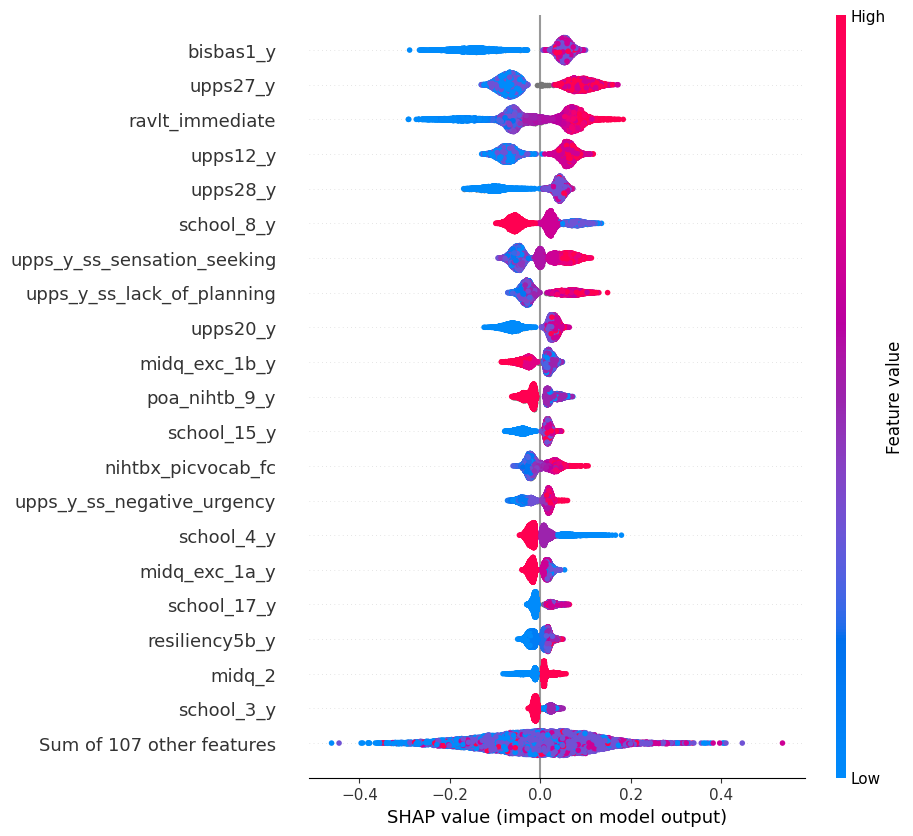

In [32]:
shap.plots.beeswarm(shap_values, max_display=21)

# SHAP dependence plots

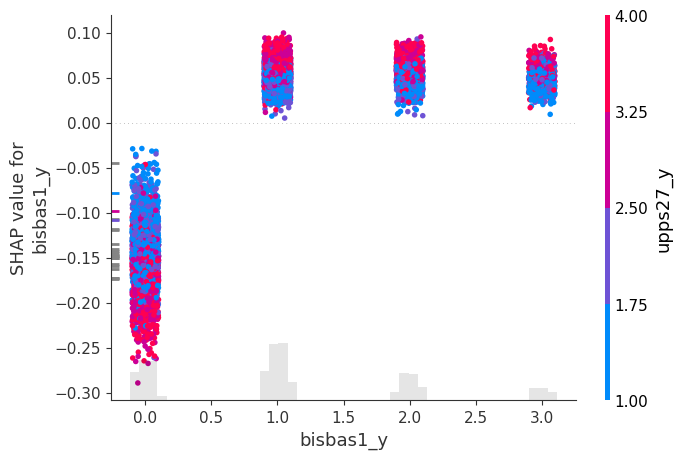

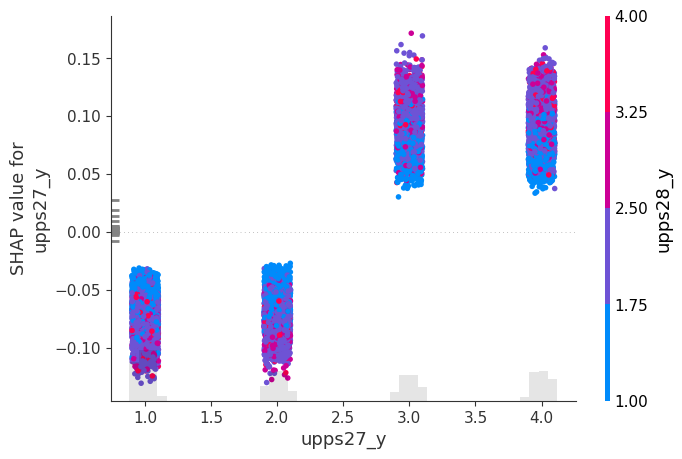

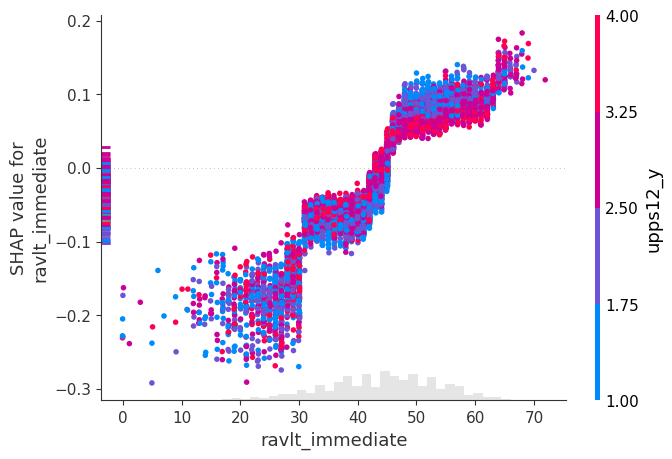

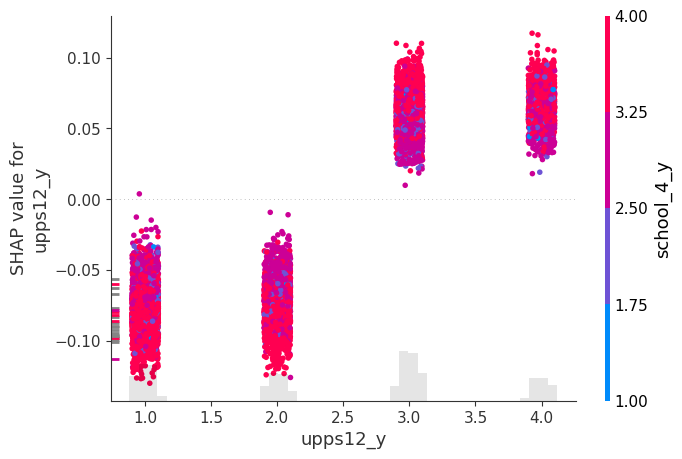

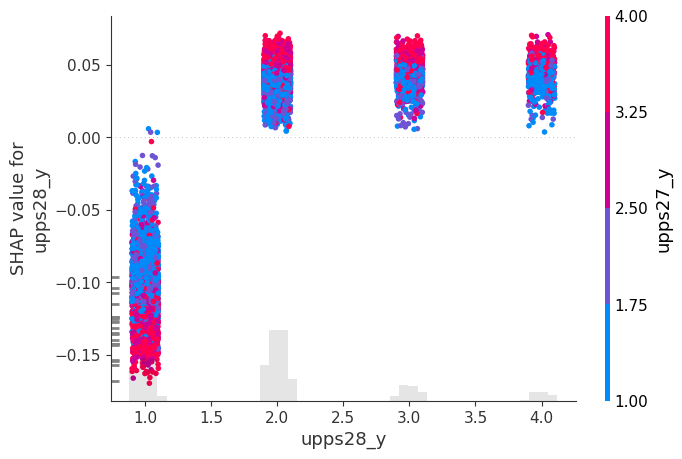

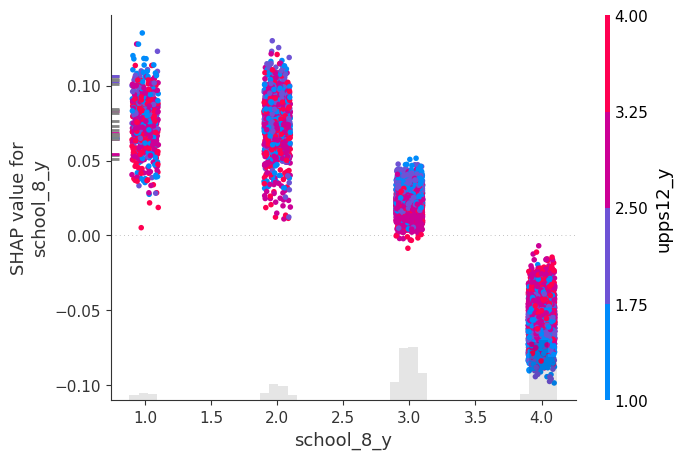

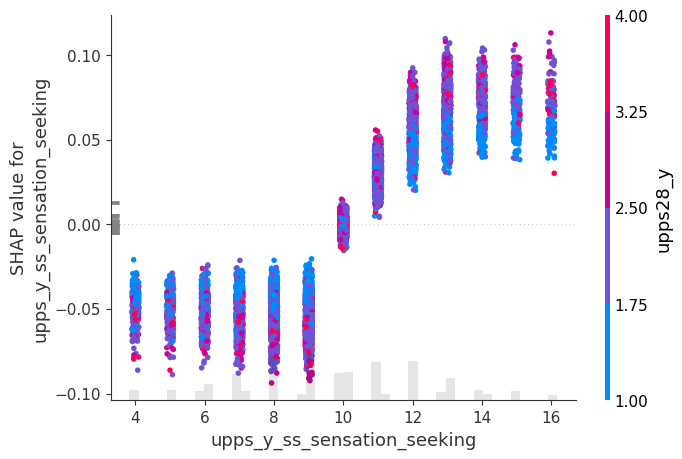

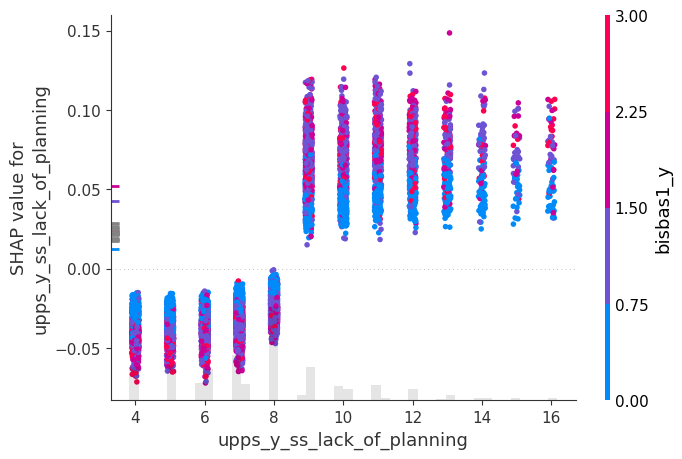

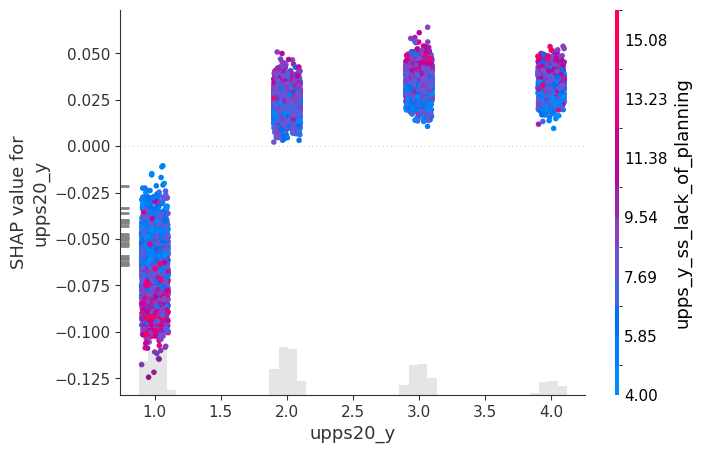

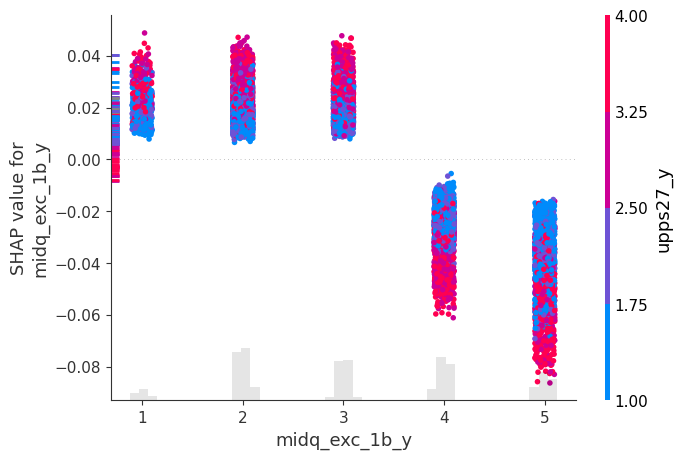

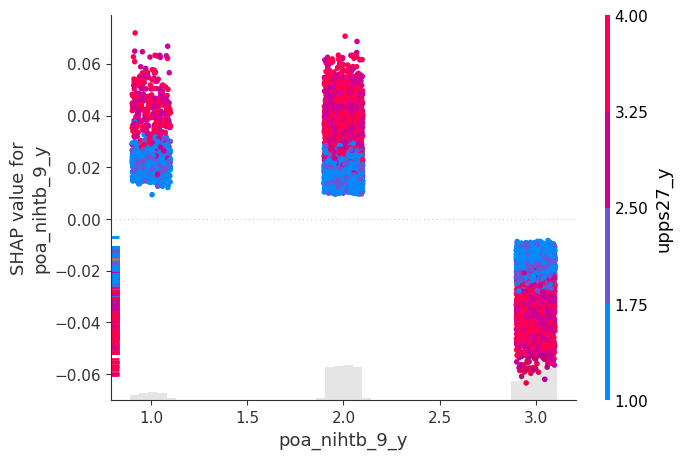

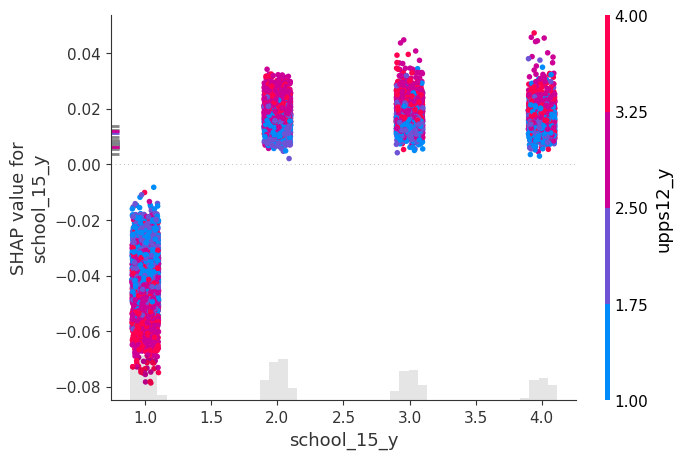

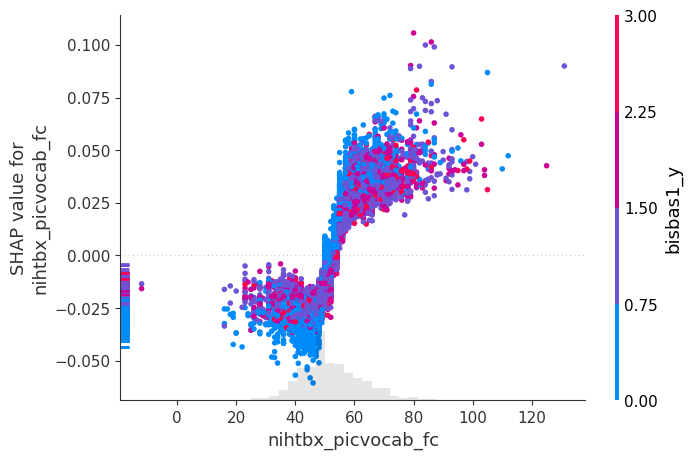

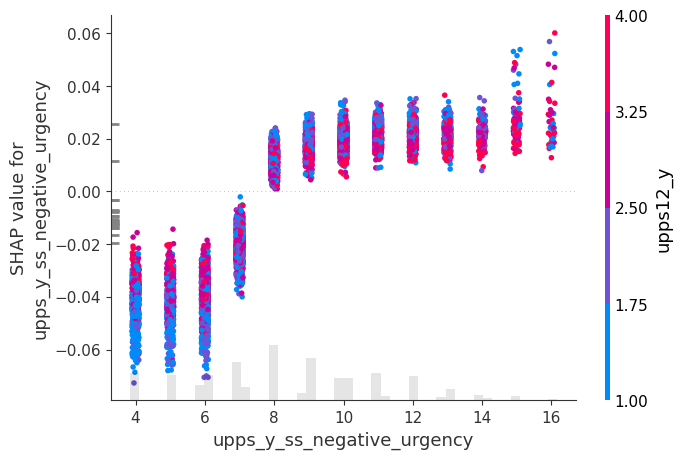

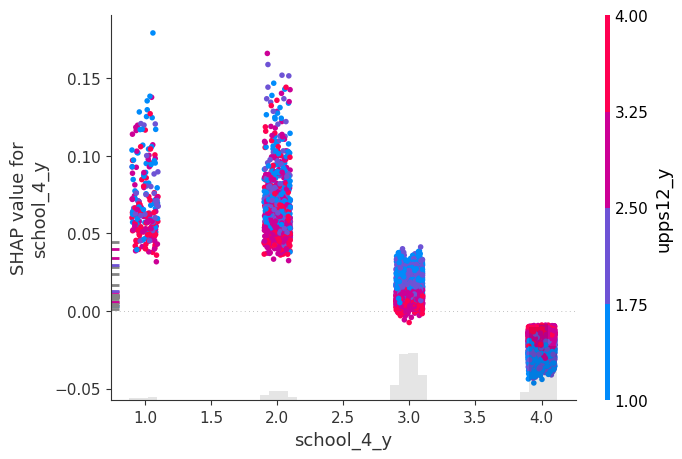

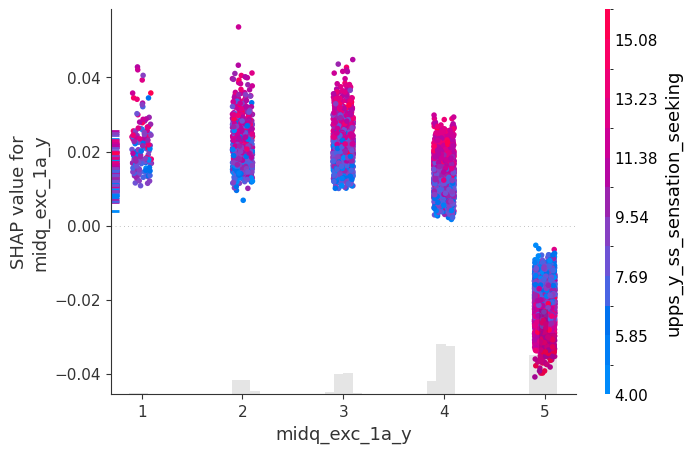

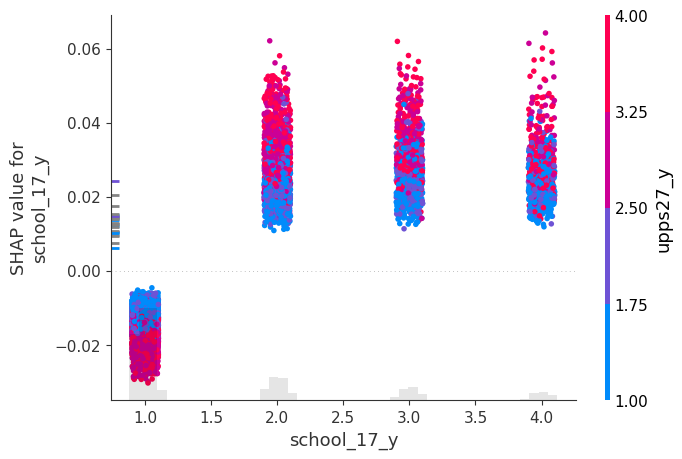

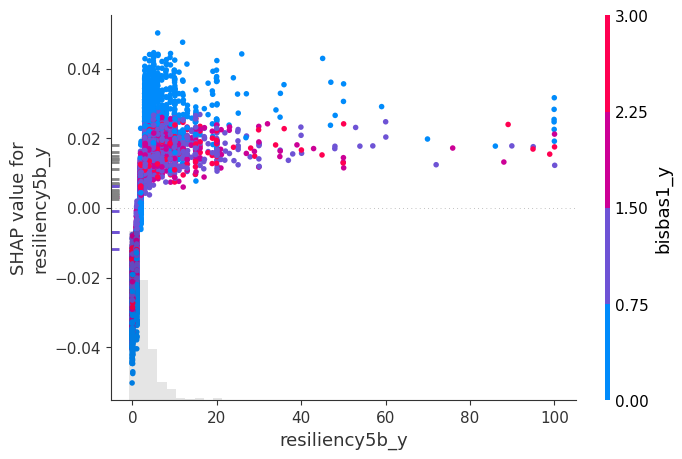

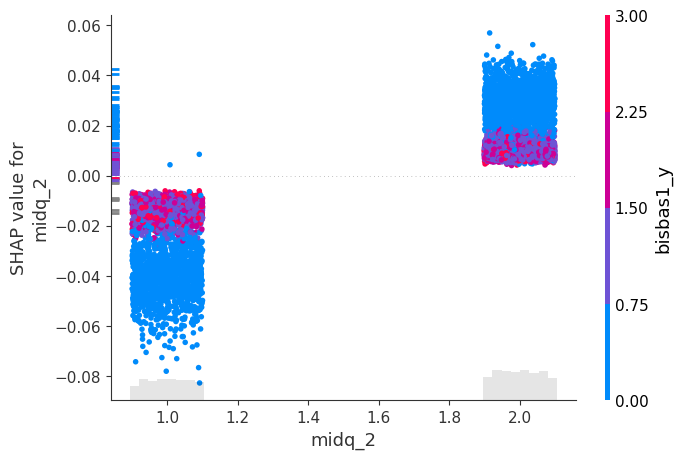

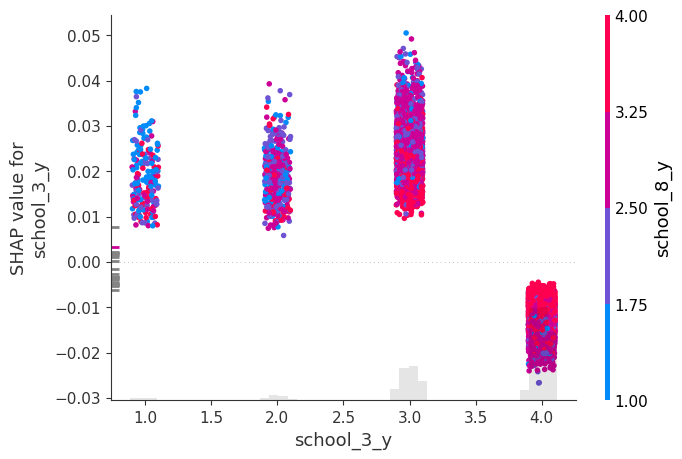

In [33]:
top_inds = np.argsort(-np.sum(np.abs(shap_values.values), 0))
for i in range(20):
    shap.plots.scatter(shap_values[:, top_inds[i]], color=shap_values)